In [1]:
from keras.datasets import mnist
from keras.layers import Dense,Flatten,Reshape
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.layers.advanced_activations import LeakyReLU
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

Using TensorFlow backend.


In [0]:
# parameters 
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows,img_cols,channels)
noise_dim = 100 # dimension of noise data used as input for generator 

In [0]:
# function that returns the generator model 
def build_generator(img_shape,noise_dim):
    model = Sequential()
    model.add(Dense(128, input_dim = noise_dim)) # fully connected Layer
    model.add(LeakyReLU(alpha = 0.01)) # LeakyRelu Activation 
    model.add(Dense(28*28*1,activation = 'tanh') )# Output Layer 
    model.add(Reshape(img_shape))
    
    return model 

In [0]:
# function that returns the discriminator model 
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape = img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

In [0]:
# combined genrator and dicriminator model as for training of generator we need output from discriminator
def build_gan(discriminator, generator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    return model 

In [0]:
# compiling discriminator 
discriminator = build_discriminator(img_shape)
discriminator.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics = ['accuracy'])

In [0]:
# compiling generator 
generator = build_generator(img_shape,noise_dim)
discriminator.trainable = False # as we train generator and discriminator seperately 
gan = build_gan(discriminator,generator) # building combined model as we want input from discrimator also 
gan.compile(loss = 'binary_crossentropy', optimizer = Adam())

In [0]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations,batch_size,sample_iteration):
    (X_train,_),(_,_) = mnist.load_data()
    # rescaling x_train b/w [-1,1 ] as we used tanh activation in generator output 
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    
    # labels for all read images [1]
    real = np.ones((batch_size, 1))
    
    # labels for all fake images [0] generated by generator 
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        # getting random real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        # generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        
        # training discriminator 
        
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # training generator 
        
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        g_loss = gan.train_on_batch(noise, real)
        
        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)

In [0]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise for 16 images 
    noise = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, noise_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(noise)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

11493376/11490434 [==============================] - 1s 0us/step


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.001729, acc.: 100.00%] [G loss: 6.311748]
2000 [D loss: 0.168213, acc.: 92.97%] [G loss: 4.279900]
3000 [D loss: 0.175658, acc.: 93.75%] [G loss: 5.058692]
4000 [D loss: 0.076498, acc.: 96.88%] [G loss: 5.500621]
5000 [D loss: 0.183272, acc.: 92.58%] [G loss: 4.331182]
6000 [D loss: 0.265922, acc.: 91.02%] [G loss: 3.693700]
7000 [D loss: 0.290245, acc.: 91.02%] [G loss: 3.893214]
8000 [D loss: 0.225385, acc.: 91.80%] [G loss: 4.342196]
9000 [D loss: 0.133797, acc.: 94.14%] [G loss: 6.303876]
10000 [D loss: 0.158574, acc.: 93.36%] [G loss: 4.595008]
11000 [D loss: 0.327732, acc.: 86.72%] [G loss: 3.667589]
12000 [D loss: 0.254966, acc.: 90.62%] [G loss: 3.807455]
13000 [D loss: 0.390264, acc.: 84.38%] [G loss: 3.821958]
14000 [D loss: 0.346960, acc.: 85.94%] [G loss: 3.147180]
15000 [D loss: 0.421596, acc.: 84.77%] [G loss: 2.543010]
16000 [D loss: 0.298182, acc.: 87.89%] [G loss: 2.923575]
17000 [D loss: 0.392489, acc.: 84.38%] [G loss: 2.742009]
18000 [D loss: 0.30461

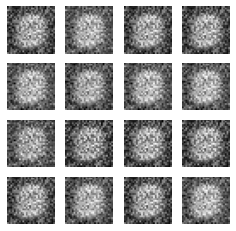

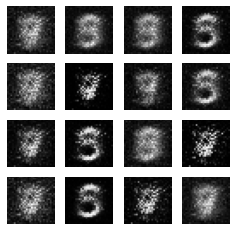

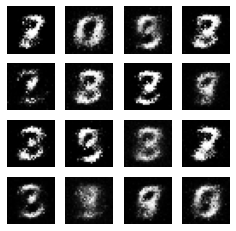

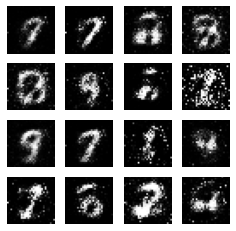

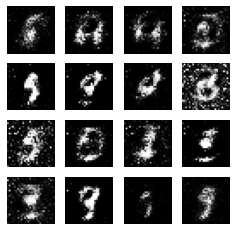

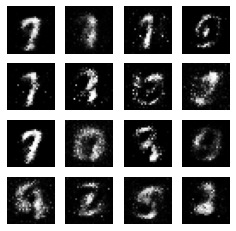

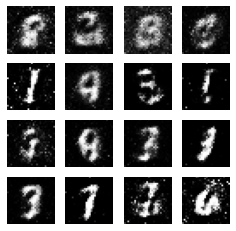

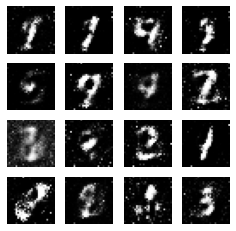

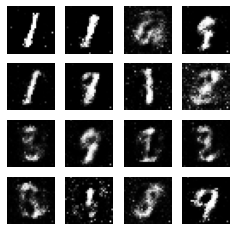

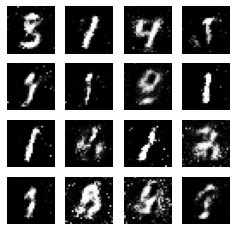

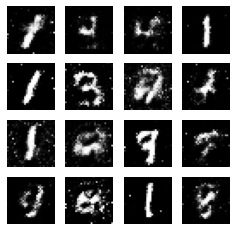

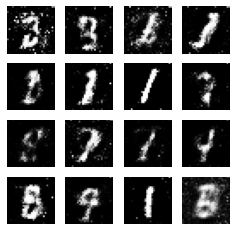

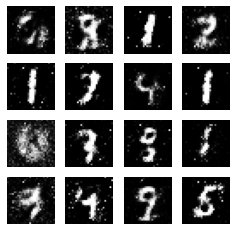

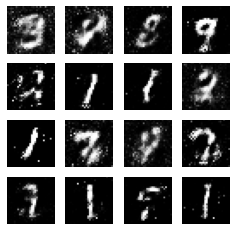

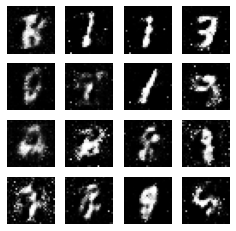

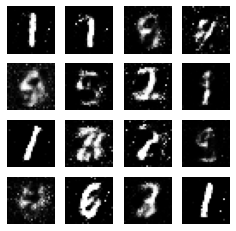

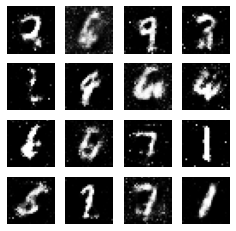

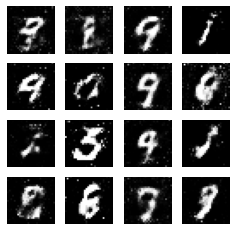

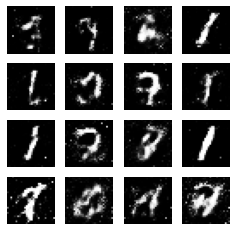

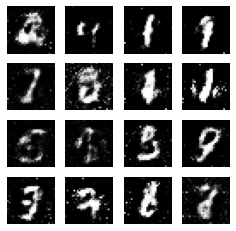

In [10]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)